<a href="https://colab.research.google.com/github/Rossiee1/multimodal-stock-vix-prediction/blob/main/MSC_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Imports & Setup

# Title: Multimodal Stock Market Prediction Using the VIX Index (Fear Index) and Historical Price Data

In [ ]:
!pip install yfinance arch ta

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 9.0 MB/s eta 0:00:00
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=643eebf58854fecbd07866100a0f4e922fa6c66ae3487065c567d6492a85e6e9
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [ ]:
# Core Libraries
import os
import warnings
import numpy as np
import pandas as pd
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Time-Series Analysis & Statistical Tests
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima.model import ARIMA

# Volatility Modeling
from arch import arch_model

# Feature Engineering & Technical Indicators
import ta
from pandas.api.types import is_numeric_dtype
from scipy.stats import skew, kurtosis

# Machine Learning Models & Metrics
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import MinMaxScaler

# Deep Learning with TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, Dropout, LSTM, GRU, Bidirectional,
    LayerNormalization, ReLU, Conv1D, MaxPooling1D, Flatten
)
from tensorflow.keras.callbacks import EarlyStopping

# Financial Data
import yfinance as yf

# Model Explainability
import shap

In [ ]:
# Plotting Styles
sns.set(style="darkgrid")
plt.rcParams["figure.figsize"] = (14, 6)
# Constants
STOCK_TICKERS = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA'][:2]
VIX_TICKER = '^VIX'
START_DATE = '2015-01-01'
END_DATE = '2024-12-31'
DATA_DIR = 'data'

In [ ]:
print(STOCK_TICKERS)

['AAPL', 'MSFT']


In [ ]:
# Create Data Directory
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

print("✅ Setup complete. Ready to fetch and process stock data.")

✅ Setup complete. Ready to fetch and process stock data.


# 2. Data Loading & Cleaning

In [ ]:
def download_stock_data(tickers, start, end):
    all_data = []

    for ticker in tickers:
        print(f"Downloading data for {ticker}...")
        df = yf.download(ticker, start=start, end=end)

        # Flatten MultiIndex columns if they exist
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.droplevel(1)

        df.reset_index(inplace=True)
        df["Ticker"] = ticker
        all_data.append(df)

    return pd.concat(all_data, axis=0, ignore_index=True)

## Download stock and VIX data

In [ ]:
stock_df = download_stock_data(STOCK_TICKERS, START_DATE, END_DATE)
vix_df = yf.download(VIX_TICKER, start=START_DATE, end=END_DATE)

# Flatten VIX columns if MultiIndex
if isinstance(vix_df.columns, pd.MultiIndex):
    vix_df.columns = vix_df.columns.droplevel(1)

vix_df.reset_index(inplace=True)
vix_df = vix_df[["Date", "Close"]].rename(columns={"Close": "VIX"})

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
vix_9d = pd.read_csv('./VIX9D_History.csv')

In [ ]:
vix_9d.head()

,DATE,OPEN,HIGH,LOW,CLOSE
0,01/04/2011,16.06,16.06,16.06,16.06
1,01/05/2011,15.57,15.57,15.57,15.57
2,01/06/2011,15.71,15.71,15.71,15.71
3,01/07/2011,15.01,15.01,15.01,15.01
4,01/10/2011,15.81,15.81,15.81,15.81


## Merge VIX into stock data

In [ ]:
merged_df = pd.merge(stock_df, vix_df, on="Date", how="left")

In [ ]:
# Drop or forward-fill missing values
merged_df.sort_values(by=["Ticker", "Date"], inplace=True)
merged_df.fillna(method="ffill", inplace=True)

## Feature Engineering: Add Returns and Z-score Normalization

In [ ]:
merged_df["Return"] = merged_df.groupby("Ticker")["Close"].transform(lambda x: x.pct_change())
merged_df["Close_Zscore"] = merged_df.groupby("Ticker")["Close"].transform(
    lambda x: (x - x.mean()) / x.std()
)

## Reordering of Columns

In [ ]:
merged_df = merged_df[["Date", "Ticker", "Open", "High", "Low", "Close", "Volume", "VIX", "Return", "Close_Zscore"]]

In [ ]:
print("Merged and cleaned data preview:")
merged_df.tail(20)

Merged and cleaned data preview:


,Date,Ticker,Open,High,Low,Close,Volume,VIX,Return,Close_Zscore,...,Rolling_Vol_5,Rolling_Vol_10,VIX_Change,VIX_MA_5,VIX_MA_10,Ticker_AAPL,Ticker_MSFT,VIX_Lag_1,VIX_Lag_3,Realized_Volatility
4936,2024-12-02,MSFT,419.955412,431.341629,419.696399,429.329376,20207200,13.340000,0.017758,2.011893,...,0.013512,0.010368,-0.012583,13.930000,15.085,False,True,13.510000,14.100000,0.013512
4937,2024-12-03,MSFT,428.193746,430.813679,426.101783,429.548553,18302000,13.300000,0.000511,2.013670,...,0.013783,0.010408,-0.002998,13.670000,14.857,False,True,13.340000,14.100000,0.013783
4938,2024-12-04,MSFT,431.371519,437.986103,430.973057,435.744720,26009400,13.450000,0.014425,2.063913,...,0.011869,0.010932,0.011278,13.540000,14.567,False,True,13.300000,13.510000,0.011869
4939,2024-12-05,MSFT,436.242823,442.957000,434.499526,440.924805,21697800,13.540000,0.011888,2.105917,...,0.007885,0.010474,0.006691,13.428000,14.205,False,True,13.450000,13.340000,0.007885
4940,2024-12-06,MSFT,440.605999,444.391464,440.078030,441.871155,18821000,12.770000,0.002146,2.113591,...,0.007631,0.009910,-0.056869,13.280000,13.795,False,True,13.540000,13.300000,0.007631
4941,2024-12-09,MSFT,440.904883,446.612918,438.812920,444.311768,19144400,14.190000,0.005523,2.133381,...,0.006058,0.009873,0.111198,13.450000,13.690,False,True,12.770000,13.450000,0.006058
4942,2024-12-10,MSFT,442.688018,447.897968,439.908695,441.632050,18469500,14.180000,-0.006031,2.111652,...,0.008134,0.010671,-0.000705,13.626000,13.648,False,True,14.190000,13.540000,0.008134
4943,2024-12-11,MSFT,442.349333,448.625223,442.349333,447.270416,19200200,13.580000,0.012767,2.157372,...,0.007706,0.009445,-0.042313,13.652000,13.596,False,True,14.180000,12.770000,0.007706
4944,2024-12-12,MSFT,447.389907,454.412924,447.389907,447.838196,20834800,13.920000,0.001269,2.161976,...,0.006837,0.007643,0.025037,13.728000,13.578,False,True,13.580000,14.190000,0.006837
4945,2024-12-13,MSFT,446.722509,449.701047,443.873446,445.556976,20177800,13.810000,-0.005094,2.143478,...,0.007798,0.008318,-0.007902,13.936000,13.608,False,True,13.920000,14.180000,0.007798


# EDA & Stationarity Testing


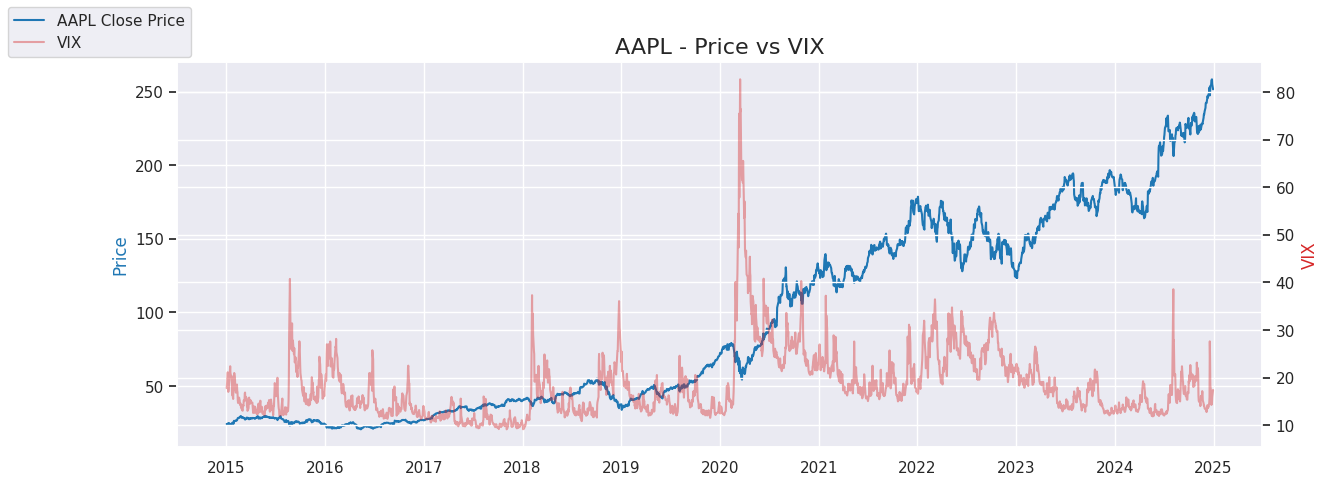

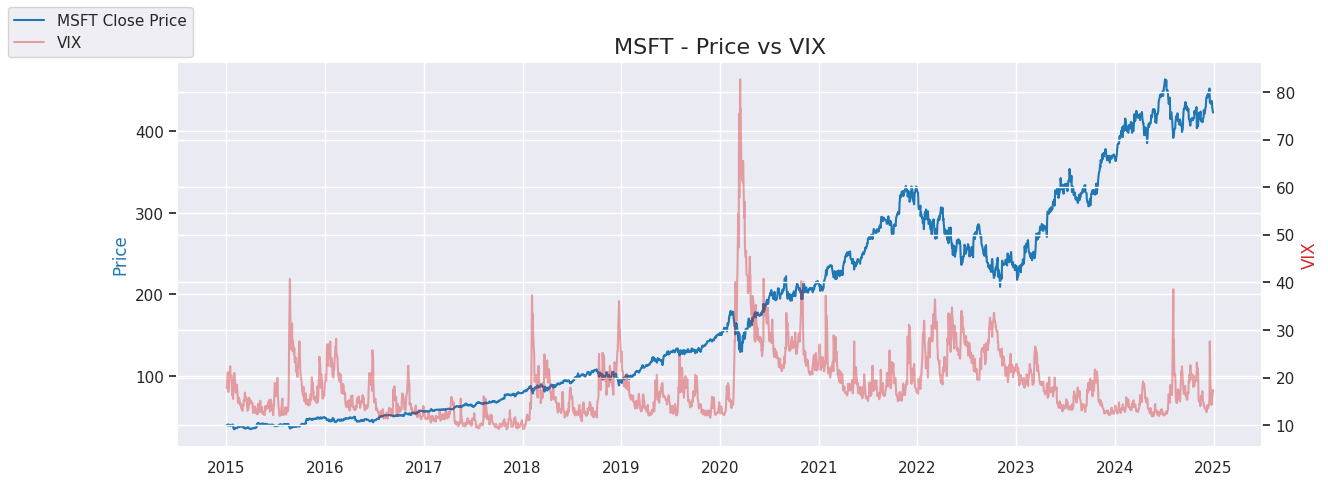

In [ ]:
def plot_price_and_vix(df, tickers):
    for ticker in tickers:
        subset = df[df['Ticker'] == ticker]

        fig, ax1 = plt.subplots(figsize=(14, 5))
        ax2 = ax1.twinx()

        ax1.plot(subset["Date"], subset["Close"], label=f"{ticker} Close Price", color='tab:blue')
        ax2.plot(subset["Date"], subset["VIX"], label="VIX", color='tab:red', alpha=0.4)

        ax1.set_title(f"{ticker} - Price vs VIX", fontsize=16)
        ax1.set_ylabel("Price", color='tab:blue')
        ax2.set_ylabel("VIX", color='tab:red')

        fig.legend(loc="upper left")
        ax1.xaxis.set_major_locator(mdates.YearLocator())
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

        plt.grid(True)
        plt.show()

plot_price_and_vix(merged_df, STOCK_TICKERS)

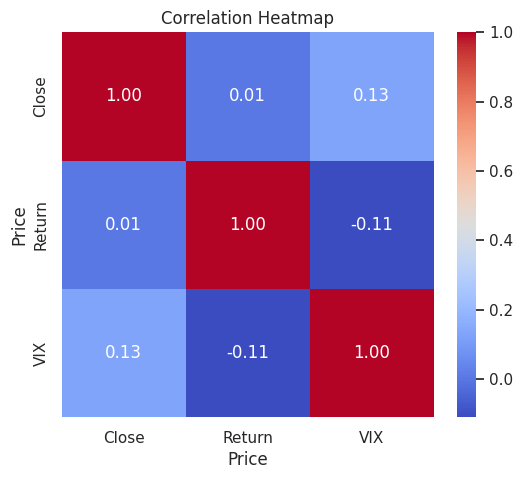

In [ ]:
# Correlation Heatmap (Price, Return, VIX)
def plot_correlation_heatmap(df):
    corr_df = df[["Close", "Return", "VIX"]].dropna()
    correlation = corr_df.corr()

    plt.figure(figsize=(6, 5))
    sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Heatmap")
    plt.show()

plot_correlation_heatmap(merged_df)

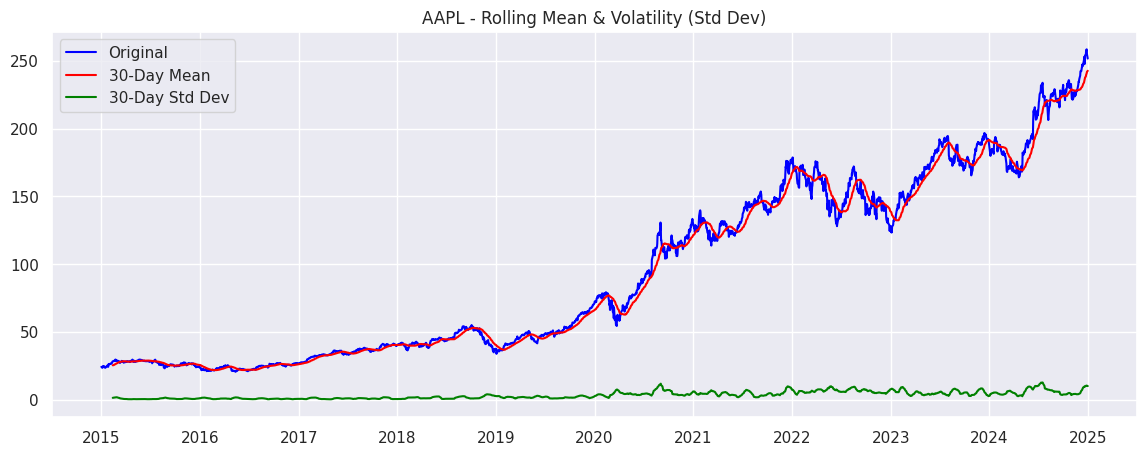

In [ ]:
# Rolling Mean & Variance (Volatility proxy)
def plot_rolling_stats(df, ticker, window=30):
    subset = df[df['Ticker'] == ticker].set_index("Date")
    close = subset["Close"]

    rolling_mean = close.rolling(window).mean()
    rolling_std = close.rolling(window).std()

    plt.figure(figsize=(14, 5))
    plt.plot(close, color='blue', label='Original')
    plt.plot(rolling_mean, color='red', label=f'{window}-Day Mean')
    plt.plot(rolling_std, color='green', label=f'{window}-Day Std Dev')
    plt.title(f'{ticker} - Rolling Mean & Volatility (Std Dev)')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_rolling_stats(merged_df, ticker=STOCK_TICKERS[0])

In [ ]:
# ADF Test for Stationarity (on Returns)
def adf_test(df, tickers):
    print("Augmented Dickey-Fuller Test (on Returns)\n")
    for ticker in tickers:
        series = df[df["Ticker"] == ticker]["Return"].dropna()
        result = adfuller(series)
        print(f"{ticker} - ADF Statistic: {result[0]:.4f}, p-value: {result[1]:.4f}")
        if result[1] < 0.05:
            print("Likely Stationary")
        else:
            print("Not Stationary")
        print("-" * 40)

adf_test(merged_df, STOCK_TICKERS)

Augmented Dickey-Fuller Test (on Returns)

AAPL - ADF Statistic: -15.6406, p-value: 0.0000
Likely Stationary
----------------------------------------
MSFT - ADF Statistic: -17.3674, p-value: 0.0000
Likely Stationary
----------------------------------------


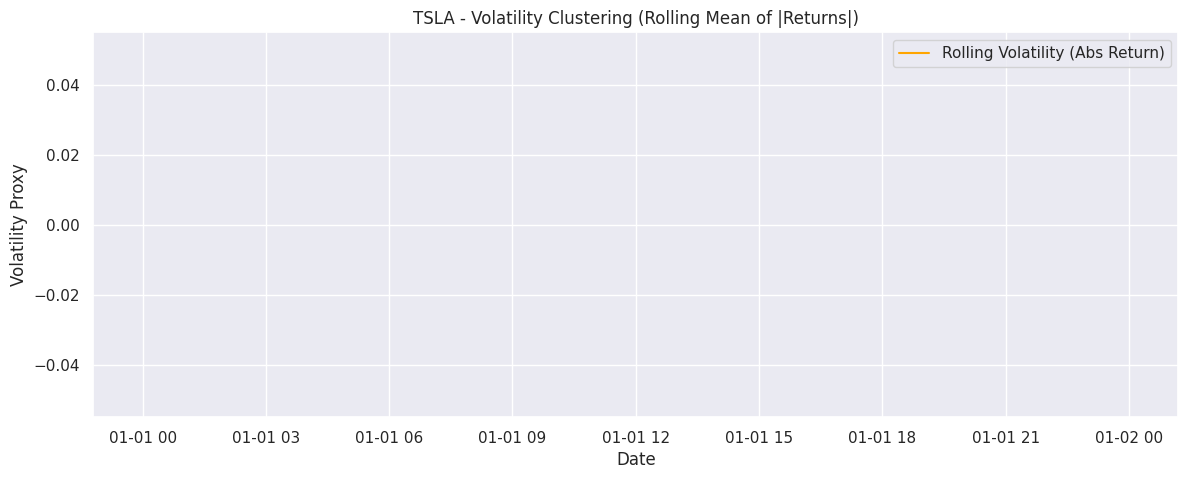

In [ ]:
# Volatility Clustering Visualization
def plot_volatility_clusters(df, ticker, window=5):
    subset = df[df["Ticker"] == ticker].copy()
    subset["Abs_Return"] = subset["Return"].abs()
    subset["Rolling_Vol"] = subset["Abs_Return"].rolling(window).mean()

    plt.figure(figsize=(14, 5))
    plt.plot(subset["Date"], subset["Rolling_Vol"], label="Rolling Volatility (Abs Return)", color="orange")
    plt.title(f"{ticker} - Volatility Clustering (Rolling Mean of |Returns|)")
    plt.xlabel("Date")
    plt.ylabel("Volatility Proxy")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_volatility_clusters(merged_df, "TSLA")

# Feature Engineering


In [ ]:
# Ensure DataFrame is sorted
merged_df.sort_values(by=["Ticker", "Date"], inplace=True)

In [ ]:
# Compute Technical Indicators (RSI, MACD)
def add_technical_indicators(df):
    dfs = []

    for ticker in df["Ticker"].unique():
        stock = df[df["Ticker"] == ticker].copy()

        # RSI (14)
        stock["RSI_14"] = ta.momentum.RSIIndicator(close=stock["Close"], window=14).rsi()

        # MACD (12, 26)
        macd = ta.trend.MACD(close=stock["Close"], window_slow=26, window_fast=12, window_sign=9)
        stock["MACD"] = macd.macd()
        stock["MACD_Signal"] = macd.macd_signal()

        dfs.append(stock)

    return pd.concat(dfs, axis=0).sort_values(by=["Ticker", "Date"]).reset_index(drop=True)

merged_df = add_technical_indicators(merged_df)

In [ ]:
# Lagged Returns
for lag in [1, 2, 3, 5, 10]:
    merged_df[f"Return_Lag_{lag}"] = merged_df.groupby("Ticker")["Return"].shift(lag)

# Rolling Volatility (e.g., 5-day and 10-day rolling std of returns)
merged_df["Rolling_Vol_5"] = merged_df.groupby("Ticker")["Return"].transform(lambda x: x.rolling(5).std())
merged_df["Rolling_Vol_10"] = merged_df.groupby("Ticker")["Return"].transform(lambda x: x.rolling(10).std())

# VIX Features
merged_df["VIX_Change"] = merged_df["VIX"].pct_change()
merged_df["VIX_MA_5"] = merged_df["VIX"].rolling(window=5).mean()
merged_df["VIX_MA_10"] = merged_df["VIX"].rolling(window=10).mean()

# One-hot Encode Ticker (for ML Models only)
one_hot_ticker = pd.get_dummies(merged_df["Ticker"], prefix="Ticker")
merged_df = pd.concat([merged_df, one_hot_ticker], axis=1)

# Drop rows with any remaining NaNs from rolling/window operations
merged_df.dropna(inplace=True)
merged_df.reset_index(drop=True, inplace=True)

# Preview Feature-Enhanced Data
print("Feature engineering complete. Sample rows:")
merged_df.head()

Feature engineering complete. Sample rows:


,Date,Ticker,Open,High,Low,Close,Volume,VIX,Return,Close_Zscore,...,Return_Lag_3,Return_Lag_5,Return_Lag_10,Rolling_Vol_5,Rolling_Vol_10,VIX_Change,VIX_MA_5,VIX_MA_10,Ticker_AAPL,Ticker_MSFT
0,2015-02-20,AAPL,28.686790,28.883062,28.559662,28.883062,195793600,14.30,0.008174,-0.993789,...,0.005902,0.012652,0.007137,0.004027,0.009271,-0.064748,15.106,16.090,True,False
1,2015-02-23,AAPL,28.999039,29.663683,28.918746,29.663683,283896400,14.56,0.027027,-0.981875,...,0.006962,0.004903,-0.008421,0.010751,0.009183,0.018182,15.080,15.817,True,False
2,2015-02-24,AAPL,29.650301,29.797505,29.255528,29.478563,276912400,13.69,-0.006241,-0.984700,...,-0.002097,0.005902,0.006643,0.012848,0.010687,-0.059753,14.658,15.331,True,False
3,2015-02-25,AAPL,29.342509,29.351433,28.581959,28.724701,298846800,13.84,-0.025573,-0.996206,...,0.008174,0.006962,0.019211,0.019328,0.014934,0.010957,14.336,14.992,True,False
4,2015-02-26,AAPL,28.724701,29.188614,28.238486,29.088249,365150000,13.91,0.012656,-0.990657,...,0.027027,-0.002097,0.023439,0.019993,0.013846,0.005058,14.060,14.687,True,False


In [ ]:
# Add lagged VIX features to capture delayed impact of market fear
merged_df["VIX_Lag_1"] = merged_df["VIX"].shift(1)
merged_df["VIX_Lag_3"] = merged_df["VIX"].shift(3)

# Add 5-day rolling standard deviation of returns as volatility target
merged_df["Realized_Volatility"] = merged_df.groupby("Ticker")["Return"].transform(lambda x: x.rolling(5).std())

# Drop rows with missing values due to rolling and shifting
merged_df.dropna(inplace=True)
merged_df.reset_index(drop=True, inplace=True)

In [ ]:
merged_df.head()

,Date,Ticker,Open,High,Low,Close,Volume,VIX,Return,Close_Zscore,...,Rolling_Vol_5,Rolling_Vol_10,VIX_Change,VIX_MA_5,VIX_MA_10,Ticker_AAPL,Ticker_MSFT,VIX_Lag_1,VIX_Lag_3,Realized_Volatility
0,2015-02-26,AAPL,28.724701,29.188614,28.238486,29.088249,365150000,13.91,0.012656,-0.990657,...,0.019993,0.013846,0.005058,14.060,14.687,True,False,13.84,14.56,0.019993
1,2015-02-27,AAPL,28.994577,29.121708,28.602036,28.651104,248059200,13.34,-0.015028,-0.997329,...,0.021208,0.014758,-0.040978,13.868,14.487,True,False,13.91,13.69,0.021208
2,2015-03-02,AAPL,28.827297,29.057023,28.615414,28.791611,192386800,13.04,0.004904,-0.995185,...,0.015261,0.014758,-0.022489,13.564,14.322,True,False,13.34,13.84,0.015261
3,2015-03-03,AAPL,28.762619,28.887518,28.568576,28.851831,151265200,13.86,0.002092,-0.994266,...,0.015658,0.014685,0.062883,13.598,14.128,True,False,13.04,13.91,0.015658
4,2015-03-04,AAPL,28.793848,28.896442,28.619881,28.668945,126665200,14.23,-0.006339,-0.997057,...,0.010654,0.014717,0.026696,13.676,14.006,True,False,13.86,13.34,0.010654


The merged_df now contains a rich set of engineered features that make your dataset multimodal, meaning it includes price, volatility (VIX), technical indicators, and categorical encodings.


What Has Been Done in Feature Engineering
1. Price-Based Features
Return: Percentage change in daily closing price.

Close_Zscore: Z-score normalization of the close price — shows how far the price is from its mean in standard deviations.

2. Technical Indicators
RSI_14: 14-day Relative Strength Index — identifies overbought/oversold conditions.

MACD and MACD_Signal: Moving Average Convergence Divergence and its signal line — used to detect momentum shifts.

3. Lagged Returns
Return_Lag_1, Return_Lag_2, ..., Return_Lag_10: Past return values used for sequence-based learning or autoregressive models.

4. Volatility Metrics
Rolling_Vol_5, Rolling_Vol_10: 5- and 10-day rolling standard deviation of returns — proxies for short-term volatility.

5. VIX Features
VIX_Change: Daily percentage change in the VIX (fear index).

VIX_MA_5, VIX_MA_10: 5- and 10-day moving averages of VIX — smoothed risk signals.

6. One-Hot Encoding for Tickers
Ticker_AAPL, Ticker_AMZN, etc.: Boolean flags (or binary) to let models distinguish between different stocks.



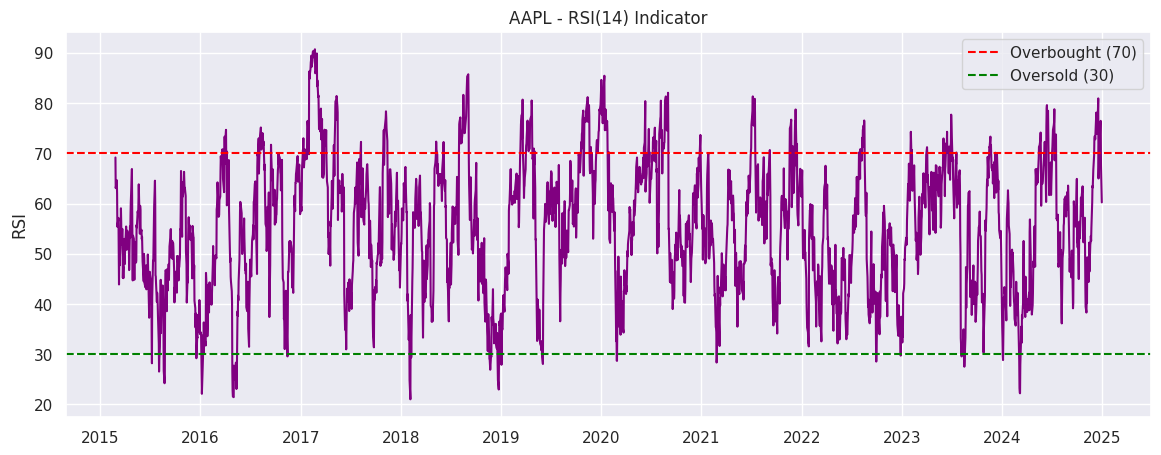

In [ ]:
# RSI Over Time
def plot_rsi(df, ticker):
    subset = df[df["Ticker"] == ticker]
    plt.figure(figsize=(14, 5))
    plt.plot(subset["Date"], subset["RSI_14"], color='purple')
    plt.axhline(70, linestyle='--', color='red', label='Overbought (70)')
    plt.axhline(30, linestyle='--', color='green', label='Oversold (30)')
    plt.title(f"{ticker} - RSI(14) Indicator")
    plt.ylabel("RSI")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_rsi(merged_df, "AAPL")

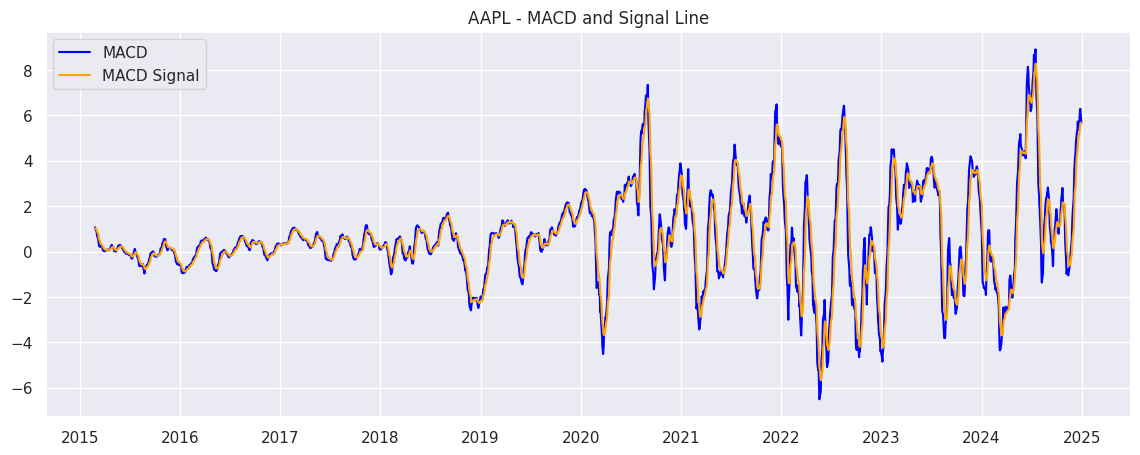

In [ ]:
# MACD vs MACD Signal
def plot_macd(df, ticker):
    subset = df[df["Ticker"] == ticker]
    plt.figure(figsize=(14, 5))
    plt.plot(subset["Date"], subset["MACD"], label="MACD", color="blue")
    plt.plot(subset["Date"], subset["MACD_Signal"], label="MACD Signal", color="orange")
    plt.title(f"{ticker} - MACD and Signal Line")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_macd(merged_df, "AAPL")

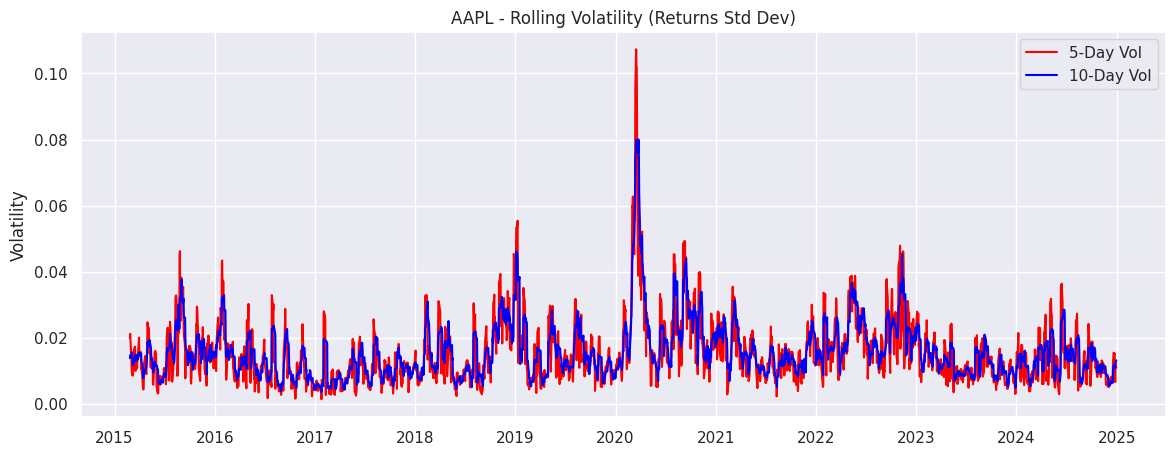

In [ ]:
# Rolling Volatility
def plot_rolling_volatility(df, ticker):
    subset = df[df["Ticker"] == ticker]
    plt.figure(figsize=(14, 5))
    plt.plot(subset["Date"], subset["Rolling_Vol_5"], label="5-Day Vol", color='red')
    plt.plot(subset["Date"], subset["Rolling_Vol_10"], label="10-Day Vol", color='blue')
    plt.title(f"{ticker} - Rolling Volatility (Returns Std Dev)")
    plt.ylabel("Volatility")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_rolling_volatility(merged_df, "AAPL")

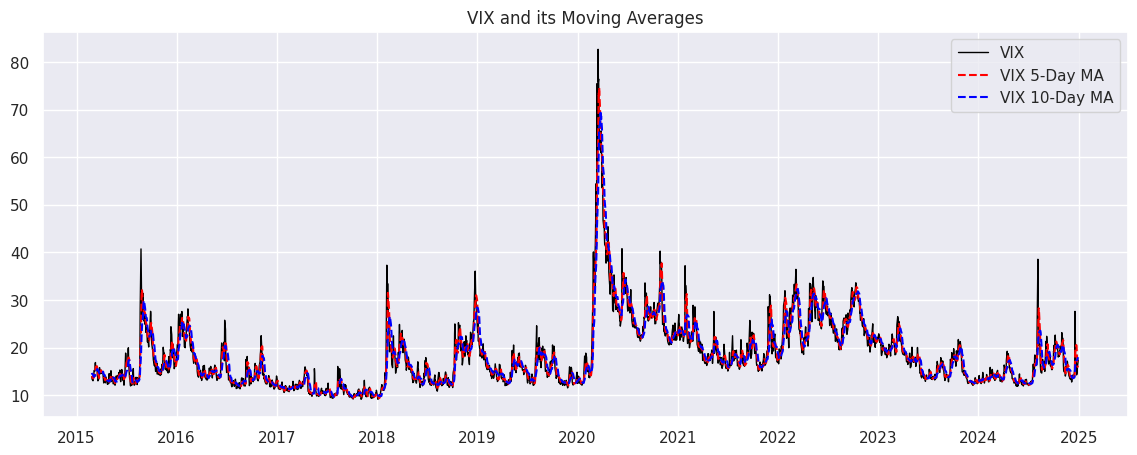

In [ ]:
# VIX Features
def plot_vix_features(df):
    plt.figure(figsize=(14, 5))
    plt.plot(df["Date"], df["VIX"], label="VIX", color='black', linewidth=1)
    plt.plot(df["Date"], df["VIX_MA_5"], label="VIX 5-Day MA", color='red', linestyle='--')
    plt.plot(df["Date"], df["VIX_MA_10"], label="VIX 10-Day MA", color='blue', linestyle='--')
    plt.title("VIX and its Moving Averages")
    plt.legend()
    plt.grid(True)
    plt.show()

# Filter only one Ticker row for date sampling
plot_vix_features(merged_df[merged_df["Ticker"] == STOCK_TICKERS[0]])

# Data Splitting


70/30 time-aware (Sort by Date, split by timestamp) split for training/testing:



In [ ]:
def time_aware_split(df, split_ratio=0.7):
    train_list = []
    test_list = []

    # Split by each Ticker
    for ticker in df["Ticker"].unique():
        sub_df = df[df["Ticker"] == ticker].sort_values("Date")
        n = len(sub_df)
        split_index = int(n * split_ratio)

        train_list.append(sub_df.iloc[:split_index])
        test_list.append(sub_df.iloc[split_index:])

    # Combine all
    train_df = pd.concat(train_list).reset_index(drop=True)
    test_df = pd.concat(test_list).reset_index(drop=True)

    return train_df, test_df

In [ ]:
# Apply the split (time aware split Ensures chronological integrity within each stock and Prevents future data from leaking into model training.)
train_df, test_df = time_aware_split(merged_df, split_ratio=0.7)

# Summary of Split
print(f"Training set shape: {train_df.shape}")
print(f"Testing set shape: {test_df.shape}")

In [ ]:
for ticker in STOCK_TICKERS:
    train_dates = train_df[train_df["Ticker"] == ticker]["Date"]
    test_dates = test_df[test_df["Ticker"] == ticker]["Date"]
    print(f"{ticker}: Train ({train_dates.min().date()} → {train_dates.max().date()}) | Test ({test_dates.min().date()} → {test_dates.max().date()})")

# Machine Learning

In [ ]:
# Feature and Target Selection
exclude_cols = ['Date', 'Ticker', 'Close']
feature_cols = [
    col for col in train_df.columns
    if col not in exclude_cols and is_numeric_dtype(train_df[col])
]
target_col = 'Close'


print("Features used for ML models:")
print(feature_cols)

# Prepare Training and Testing Matrices
X_train = train_df[feature_cols]
y_train = train_df[target_col]

X_test = test_df[feature_cols]
y_test = test_df[target_col]

In [ ]:
# Evaluation Function
def evaluate_model(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{name} Evaluation:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"R²  : {r2_score(y_true, y_pred):.4f}")

In [ ]:
def plot_predictions(test_df, preds, model_name, ticker="AAPL"):
    df = test_df.copy()
    df["Prediction"] = preds
    df = df[df["Ticker"] == ticker]

    plt.figure(figsize=(14, 5))
    plt.plot(df["Date"], df["Close"], label="Actual", color='blue')
    plt.plot(df["Date"], df["Prediction"], label=f"{model_name} Prediction", color='orange')
    plt.title(f"{ticker} - {model_name} Close Price Prediction")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    """Compute MAPE (%) – scale-independent metric"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_mask = y_true != 0
    return np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100

In [ ]:
def directional_accuracy(y_true, y_pred):
    """Percent of times model correctly predicted price movement direction"""
    true_direction = np.sign(np.diff(y_true))
    pred_direction = np.sign(np.diff(y_pred))
    return np.mean(true_direction == pred_direction)

In [ ]:
def plot_predictions(test_df, preds, model_name, ticker="AAPL"):
    df = test_df.copy()
    df["Prediction"] = preds
    df = df[df["Ticker"] == ticker]

    plt.figure(figsize=(14, 5))
    plt.plot(df["Date"], df["Close"], label="Actual", color='blue')
    plt.plot(df["Date"], df["Prediction"], label=f"{model_name} Prediction", color='orange')
    plt.title(f"{ticker} - {model_name} Close Price Prediction")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def time_aware_split(df, split_ratio=0.7):
    train_list, test_list = [], []
    for ticker in df["Ticker"].unique():
        sub_df = df[df["Ticker"] == ticker].sort_values("Date")
        split_idx = int(len(sub_df) * split_ratio)
        train_list.append(sub_df.iloc[:split_idx])
        test_list.append(sub_df.iloc[split_idx:])
    return pd.concat(train_list).reset_index(drop=True), pd.concat(test_list).reset_index(drop=True)

In [ ]:
def plot_volatility_prediction(df, preds, model_name, ticker="AAPL"):
    """ Visualization for high VIX regime """
    df = df.copy()
    df["Prediction"] = preds
    df = df[df["Ticker"] == ticker]

    plt.figure(figsize=(14, 5))
    plt.plot(df["Date"], df["Realized_Volatility"], label="Actual", color="blue")
    plt.plot(df["Date"], df["Prediction"], label=f"{model_name} Prediction", color="orange")
    plt.title(f"{ticker} - {model_name} Volatility Prediction (High VIX)")
    plt.xlabel("Date")
    plt.ylabel("5-Day Realized Volatility")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def plot_multi_ticker_volatility_prediction(df, rf_preds, xgb_preds, tickers, models=["rf", "xgb"]):
    """
    Plots actual vs predicted volatility for multiple tickers on one chart.

    Parameters:
    - df: Test DataFrame (must include 'Date', 'Ticker', 'Realized_Volatility')
    - rf_preds: Array of predictions from Random Forest
    - xgb_preds: Array of predictions from XGBoost
    - tickers: List of ticker symbols to include in the plot
    - models: List of model identifiers to plot ("rf", "xgb", or both)
    """
    df = df.copy()

    if "rf" in models:
        df["RF_Pred"] = rf_preds
    if "xgb" in models:
        df["XGB_Pred"] = xgb_preds

    df = df[df["Ticker"].isin(tickers)]

    plt.figure(figsize=(16, 6))

    for ticker in tickers:
        sub = df[df["Ticker"] == ticker]
        plt.plot(sub["Date"], sub["Realized_Volatility"], linestyle='--', label=f"{ticker} Actual")
        if "rf" in models:
            plt.plot(sub["Date"], sub["RF_Pred"], label=f"{ticker} RF", alpha=0.6)
        if "xgb" in models:
            plt.plot(sub["Date"], sub["XGB_Pred"], label=f"{ticker} XGB", alpha=0.6)

    plt.title("Volatility Prediction (Actual vs RF & XGB) for Selected Tickers")
    plt.xlabel("Date")
    plt.ylabel("5-Day Realized Volatility")
    plt.legend(loc="upper left", bbox_to_anchor=(1.01, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
def evaluate_model(name, y_true, y_pred):
    """ Evaluation Function """
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"\n{name} Volatility Prediction:")
    print(f"RMSE: {rmse:.6f}")
    print(f"MAE : {mean_absolute_error(y_true, y_pred):.6f}")
    print(f"R²  : {r2_score(y_true, y_pred):.4f}")

## Random Forest

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

In [ ]:
rf_preds = rf_model.predict(X_test)

In [ ]:
evaluate_model("Random Forest", y_test, rf_preds)

In [ ]:
plot_predictions(test_df, rf_preds, "Random Forest", ticker="AAPL")

In [ ]:
# ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']
plot_predictions(test_df, rf_preds, "Random Forest", ticker="AAPL")

####  High VIX Regime Performance

In [ ]:
# Filter test data where VIX is high (e.g., > 25)
high_vix_df = test_df[test_df["VIX"] > 25]
X_high_vix = high_vix_df[feature_cols]
y_high_vix = high_vix_df[target_col]

# Predict in high-VIX regime
rf_high_preds = rf_model.predict(X_high_vix)

####  Evaluate High VIX Regime Performance

In [ ]:
print("\nHigh VIX Period Performance (VIX > 25):")
evaluate_model("Random Forest (High VIX)", y_high_vix, rf_high_preds)

In [ ]:
# Ablation Study: Without VIX
vix_features = [col for col in feature_cols if "VIX" in col]
feature_cols_no_vix = [col for col in feature_cols if col not in vix_features]

# Train RF without VIX features
rf_no_vix = RandomForestRegressor(n_estimators=100, random_state=42)
rf_no_vix.fit(train_df[feature_cols_no_vix], train_df[target_col])
rf_preds_no_vix = rf_no_vix.predict(test_df[feature_cols_no_vix])

# Evaluate ablation
print("Ablation Study (Without VIX features):")
evaluate_model("Random Forest (No VIX)", y_test, rf_preds_no_vix)
print(f"MAPE (No VIX): {mean_absolute_percentage_error(y_test, rf_preds_no_vix):.2f}%")

## XGBOOST

In [ ]:
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

In [ ]:
xgb_model.fit(X_train, y_train)

In [ ]:
xgb_preds = xgb_model.predict(X_test)

In [ ]:
evaluate_model("XGBoost", y_test, xgb_preds)

In [ ]:
plot_predictions(test_df, xgb_preds, "XGBoost", ticker="AAPL")

In [ ]:
# Compute additional metrics
print("\n📈 Extended Metrics:")
print(f"MAPE (RF): {mean_absolute_percentage_error(y_test, rf_preds):.2f}%")
print(f"DA   (RF): {directional_accuracy(y_test.values, rf_preds):.2%}")

In [ ]:
# Market Regime Analysis: High VIX Periods

# Define high VIX regime: VIX > 25
high_vix_df = test_df[test_df["VIX"] > 25]

if not high_vix_df.empty:
    rf_preds_high = rf_model.predict(high_vix_df[feature_cols])
    print("Market Regime Evaluation (High VIX > 25):")
    evaluate_model("Random Forest (High VIX)", high_vix_df["Close"], rf_preds_high)
else:
    print("No high-VIX periods found in test set.")

In [ ]:
# Feature Importance Visualization (Permutation Importance)
perm_result = permutation_importance(
    rf_model, X_test, y_test, n_repeats=10, random_state=42, scoring='neg_mean_squared_error'
)

In [ ]:
# Format and sort results
perm_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': perm_result.importances_mean
}).sort_values(by='Importance', ascending=False)


In [ ]:
# Plot Top 15
plt.figure(figsize=(12, 6))
sns.barplot(data=perm_df.head(15), x='Importance', y='Feature', palette='viridis')
plt.title("🔍 Permutation Importance - Random Forest")
plt.tight_layout()
plt.grid(True)
plt.show()

# Prediction Plot for Sample Ticker

# Plot for AAPL (change to other tickers as needed)
# plot_predictions(test_df, rf_preds, "Random Forest", ticker="AAPL")
# plot_predictions(test_df, xgb_preds, "XGBoost", ticker="AAPL")

| Topic                         | Research Implication                                    |
| ----------------------------- | ------------------------------------------------------- |
| VIX contribution              | Quantify its predictive power & interactions with price |
| Volatility regime performance | Show model robustness in volatile vs stable periods     |
| Lag effects of VIX            | Does VIX impact prediction with 1–2 day lag?            |
| Generalizability              | Across stocks (AAPL vs TSLA), is VIX equally important? |
| Overfitting Check             | Compare test vs train performance; validate with CV     |


In [ ]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("SHAP Feature Importance (XGBoost - Volatility Prediction)")
plt.tight_layout()
plt.show()

In [ ]:
# Plot Top 15
plt.figure(figsize=(12, 6))
sns.barplot(data=perm_df.head(15), x='Importance', y='Feature', palette='viridis')
plt.title("🔍 Permutation Importance - Random Forest")
plt.tight_layout()
plt.grid(True)
plt.show()


# --------------------------------------------
# STEP 5: High VIX Regime Performance
# --------------------------------------------

# Filter test data where VIX is high (e.g., > 25)
high_vix_df = test_df[test_df["VIX"] > 25]
X_high_vix = high_vix_df[feature_cols]
y_high_vix = high_vix_df[target_col]

# Predict in high-VIX regime
rf_high_preds = rf_model.predict(X_high_vix)
xgb_high_preds = xgb_model.predict(X_high_vix)

print("\nHigh VIX Period Performance (VIX > 25):")
evaluate_model("Random Forest (High VIX)", y_high_vix, rf_high_preds)
evaluate_model("XGBoost (High VIX)", y_high_vix, xgb_high_preds)

In [ ]:
# Plot predictions for a sample stock
plot_volatility_prediction(high_vix_df, rf_high_preds, "Random Forest", ticker="AAPL")
# plot_volatility_prediction(high_vix_df, xgb_high_preds, "XGBoost", ticker="AAPL")

In [ ]:
# plot_multi_ticker_volatility_prediction(test_df, rf_preds, xgb_preds, ["AAPL", "AMZN", "TSLA"])


# Plot both models
# plot_multi_ticker_volatility_prediction(test_df, rf_preds, xgb_preds, ["AAPL", "TSLA"], models=["rf", "xgb"])

# # Plot both models
# plot_multi_ticker_volatility_prediction(test_df, rf_preds, xgb_preds, ["AAPL", "TSLA"], models=["rf", "xgb"])

# # Plot only Random Forest
# plot_multi_ticker_volatility_prediction(test_df, rf_preds, xgb_preds, ["AAPL"], models=["rf"])

# Plot only XGBoost
plot_multi_ticker_volatility_prediction(test_df, rf_preds, xgb_preds, ["AMZN"], models=["xgb"])


# What Does **High VIX** Mean?

The **VIX** (Volatility Index), also called the **“Fear Index,”** measures the market’s **expected volatility** over the next 30 days based on options pricing from the S\&P 500.

---

### 🔍 Interpretation:

| VIX Level   | Meaning                                 | Market Implication                          |
| ----------- | --------------------------------------- | ------------------------------------------- |
| **< 15**    | Low volatility expected                 | Calm, stable markets                        |
| **15 – 25** | Normal volatility                       | Typical day-to-day uncertainty              |
| **> 25**    | High volatility expected (**High VIX**) | Market fear, stress, or panic               |
| **> 40**    | Extreme volatility                      | Crisis-level fear (e.g., 2008, COVID crash) |

---

### 🧠 High VIX Means:

* **Investors expect large price swings** (volatility) in the near future.
* **Fear and uncertainty are high** — often triggered by:

  * Economic shocks
  * War/political instability
  * Financial crises
  * Fed announcements or interest rate hikes

---

### 📉 How It Affects the Market:

* Stock prices may **drop sharply** or fluctuate erratically.
* **Risk premiums rise** — investors demand higher compensation for uncertainty.
* **Safe-haven assets** like gold and government bonds tend to gain.
* Traders often reduce leverage or hedge portfolios.

---

### 💡 In Your Research Context:

> A **high VIX regime (e.g., VIX > 25)** represents a **high-risk market period**. Your goal is to evaluate whether your ML models **perform better or worse during these periods**, and whether the **inclusion of VIX-related features improves volatility forecasting**.


# Time-Series Models

## ARIMA-GARCH Hybrid

 Feed ARIMA residuals into GARCH to capture both mean and volatility dynamics — strong classical baseline.

In [ ]:
# def test_stationarity(series, title=""):
#     result = adfuller(series.dropna())
#     print(f"ADF Test - {title}")
#     print(f"ADF Statistic: {result[0]:.4f}")
#     print(f"p-value: {result[1]:.4f}")
#     print(f"{'Stationary' if result[1] < 0.05 else 'Non-stationary'}\n")

# def walk_forward_arima_garch(df, ticker, arima_order=(1, 1, 1), garch_order=(1, 1), window_size=200):
#     """
#     Refactored ARIMA-GARCH model with walk-forward (rolling) forecast.
#     Predicts volatility dynamically over time.
#     """
#     df_ticker = df[df["Ticker"] == ticker].copy()
#     df_ticker.set_index("Date", inplace=True)
#     returns = df_ticker["Return"].dropna()

#     test_size = int(len(returns) * 0.3)
#     train_size = len(returns) - test_size

#     actual_volatility = []
#     forecasted_volatility = []
#     test_dates = []

#     for t in range(train_size, len(returns) - 5):
#         train_window = returns.iloc[t - window_size:t]

#         # Fit ARIMA model
#         try:
#             arima_model = ARIMA(train_window, order=arima_order).fit()
#             resid = arima_model.resid

#             # Fit GARCH on ARIMA residuals
#             garch_model = arch_model(resid, vol='Garch', p=garch_order[0], q=garch_order[1])
#             garch_fitted = garch_model.fit(disp="off")

#             # Forecast 1-step ahead volatility
#             forecast = garch_fitted.forecast(horizon=1)
#             pred_vol = np.sqrt(forecast.variance.values[-1][0])
#         except:
#             pred_vol = np.nan

#         # Actual realized volatility (next 5-day rolling std)
#         actual_vol = returns.iloc[t:t + 5].std()

#         if not np.isnan(pred_vol) and not np.isnan(actual_vol):
#             forecasted_volatility.append(pred_vol)
#             actual_volatility.append(actual_vol)
#             test_dates.append(returns.index[t + 5])

#     # Convert to Series
#     actual_series = pd.Series(actual_volatility, index=test_dates)
#     pred_series = pd.Series(forecasted_volatility, index=test_dates)

#     # Evaluation
#     rmse = np.sqrt(mean_squared_error(actual_series, pred_series))
#     mae = mean_absolute_error(actual_series, pred_series)

#     print(f"\n{ticker} ARIMA-GARCH (Walk-Forward) Evaluation:")
#     print(f"RMSE: {rmse:.6f}")
#     print(f"MAE : {mae:.6f}")

#     # Plotting
#     plt.figure(figsize=(14, 5))
#     plt.plot(actual_series, label="Actual 5-Day Volatility")
#     plt.plot(pred_series, label="GARCH Forecasted Volatility", alpha=0.75)
#     plt.title(f"{ticker} - Walk-Forward ARIMA-GARCH Volatility Forecast")
#     plt.xlabel("Date")
#     plt.ylabel("Volatility")
#     plt.grid(True)
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

In [ ]:
# Example for AAPL
# walk_forward_arima_garch(merged_df, ticker="AAPL")

In [ ]:
def batch_walk_forward_arima_garch(df, tickers, arima_order=(1, 1, 1), garch_order=(1, 1), window_size=200):
    """
    Batch ARIMA-GARCH walk-forward volatility forecasting for multiple tickers.
    Returns a DataFrame of evaluation metrics (RMSE, MAE) per ticker.
    """
    results = []

    for ticker in tickers:
        print(f"\nProcessing {ticker}...")

        df_ticker = df[df["Ticker"] == ticker].copy()
        df_ticker.set_index("Date", inplace=True)
        returns = df_ticker["Return"].dropna()

        test_size = int(len(returns) * 0.3)
        train_size = len(returns) - test_size

        actual_volatility = []
        forecasted_volatility = []
        test_dates = []

        for t in range(train_size, len(returns) - 5):
            train_window = returns.iloc[t - window_size:t]

            try:
                arima_model = ARIMA(train_window, order=arima_order).fit()
                resid = arima_model.resid

                garch_model = arch_model(resid, vol='Garch', p=garch_order[0], q=garch_order[1])
                garch_fitted = garch_model.fit(disp="off")

                forecast = garch_fitted.forecast(horizon=1)
                pred_vol = np.sqrt(forecast.variance.values[-1][0])
            except:
                pred_vol = np.nan

            actual_vol = returns.iloc[t:t + 5].std()

            if not np.isnan(pred_vol) and not np.isnan(actual_vol):
                forecasted_volatility.append(pred_vol)
                actual_volatility.append(actual_vol)
                test_dates.append(returns.index[t + 5])

        if actual_volatility and forecasted_volatility:
            actual_series = pd.Series(actual_volatility, index=test_dates)
            pred_series = pd.Series(forecasted_volatility, index=test_dates)

            rmse = np.sqrt(mean_squared_error(actual_series, pred_series))
            mae = mean_absolute_error(actual_series, pred_series)

            results.append({"Ticker": ticker, "RMSE": rmse, "MAE": mae})
        else:
            results.append({"Ticker": ticker, "RMSE": None, "MAE": None})

    results_df = pd.DataFrame(results)
    return results_df

In [ ]:
# Example batch run
arima_garch_metrics = batch_walk_forward_arima_garch(merged_df, tickers=STOCK_TICKERS)
arima_garch_metrics.head()

## VAR (Vector Autoregression)

Captures interdependencies between VIX and price series in a multivariate time frame (price + VIX)

In [ ]:
def test_stationarity(series, title=""):
    result = adfuller(series.dropna())
    print(f"ADF Test - {title}")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print(f"{'Stationary' if result[1] < 0.05 else 'Non-stationary'}\n")

def prepare_var_data(df, ticker):
    df_ticker = df[df["Ticker"] == ticker].copy()
    df_ticker.set_index("Date", inplace=True)
    df_var = df_ticker[["Close", "VIX"]].dropna()

    # Take log returns of Close to stabilize variance
    df_var["LogReturn"] = np.log(df_var["Close"]).diff()
    df_var["VIX_Change"] = df_var["VIX"].pct_change()

    df_var.dropna(inplace=True)
    df_var = df_var[["LogReturn", "VIX_Change"]]

    # Stationarity test
    test_stationarity(df_var["LogReturn"], title=f"{ticker} LogReturn")
    test_stationarity(df_var["VIX_Change"], title=f"{ticker} VIX_Change")

    return df_var

def train_var_model(df_var, maxlags=5):
    model = VAR(df_var)
    results = model.fit(maxlags=maxlags, ic='aic')
    return results

def forecast_var_model(model, df_var, steps=10):
    forecast_input = df_var.values[-model.k_ar:]
    forecast = model.forecast(y=forecast_input, steps=steps)
    forecast_df = pd.DataFrame(forecast, columns=df_var.columns)
    return forecast_df

def plot_var_forecast(actual_df, forecast_df, ticker):
    plt.figure(figsize=(14, 5))
    plt.plot(actual_df.index[-len(forecast_df):], actual_df["LogReturn"].iloc[-len(forecast_df):], label="Actual LogReturn")
    plt.plot(actual_df.index[-len(forecast_df):], forecast_df["LogReturn"], label="Forecasted LogReturn", linestyle='--')
    plt.title(f"{ticker} - VAR Forecast (LogReturn)")
    plt.xlabel("Date")
    plt.ylabel("Log Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def evaluate_var(actual_df, forecast_df):
    y_true = actual_df["LogReturn"].iloc[-len(forecast_df):]
    y_pred = forecast_df["LogReturn"]
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"RMSE: {rmse:.6f}")
    print(f"MAE : {mae:.6f}")

In [ ]:
# Example usage for AAPL
df_var_aapl = prepare_var_data(merged_df, ticker="AAPL")
var_model = train_var_model(df_var_aapl)
var_forecast = forecast_var_model(var_model, df_var_aapl, steps=20)
plot_var_forecast(df_var_aapl, var_forecast, ticker="AAPL")
evaluate_var(df_var_aapl, var_forecast)

In [ ]:
def prepare_var_data(df, ticker):
    df_ticker = df[df["Ticker"] == ticker].copy()
    df_ticker.set_index("Date", inplace=True)
    df_var = df_ticker[["Close", "VIX"]].dropna()

    # Log return and VIX percentage change
    df_var["LogReturn"] = np.log(df_var["Close"]).diff()
    df_var["VIX_Change"] = df_var["VIX"].pct_change()

    df_var.dropna(inplace=True)
    df_var = df_var[["LogReturn", "VIX_Change"]]

    return df_var

def walk_forward_var(df_var, steps=30):
    """
    Perform walk-forward VAR forecasting with automatic lag selection.
    Returns actual and predicted values.
    """
    train_size = int(len(df_var) * 0.7)

    actual_vals = []
    predicted_vals = []
    forecast_dates = []

    for t in range(train_size, len(df_var) - 1):
        train_window = df_var.iloc[:t]
        try:
            model = VAR(train_window)
            lag_order = model.select_order(maxlags=10).aic
            results = model.fit(lag_order)
            forecast = results.forecast(train_window.values[-lag_order:], steps=1)
            predicted_vals.append(forecast[0][0])
            actual_vals.append(df_var.iloc[t + 1]["LogReturn"])
            forecast_dates.append(df_var.index[t + 1])
        except:
            continue

    return pd.Series(actual_vals, index=forecast_dates), pd.Series(predicted_vals, index=forecast_dates)

def evaluate_and_plot_var(ticker, actual, predicted):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)

    print(f"\n{ticker} VAR Walk-Forward Evaluation:")
    print(f"RMSE: {rmse:.6f}")
    print(f"MAE : {mae:.6f}")

    # Plot
    plt.figure(figsize=(14, 5))
    plt.plot(actual.index, actual, label="Actual LogReturn")
    plt.plot(predicted.index, predicted, label="Forecasted LogReturn", linestyle='--')
    plt.title(f"{ticker} - Walk-Forward VAR Forecast")
    plt.xlabel("Date")
    plt.ylabel("Log Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def batch_var_evaluation(df, tickers):
    results = []
    for ticker in tickers:
        print(f"\nRunning VAR for {ticker}...")
        df_var = prepare_var_data(df, ticker)
        actual, predicted = walk_forward_var(df_var)
        evaluate_and_plot_var(ticker, actual, predicted)
        rmse = np.sqrt(mean_squared_error(actual, predicted))
        mae = mean_absolute_error(actual, predicted)
        results.append({"Ticker": ticker, "RMSE": rmse, "MAE": mae})
    return pd.DataFrame(results)

In [ ]:
# Run batch VAR on selected tickers
var_results_df = batch_var_evaluation(merged_df, STOCK_TICKERS)

# Deep Learning

#### Utility functions

In [ ]:
# Model architecture update
def build_advanced_lstm(input_shape):
    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape),
        LayerNormalization(),
        Bidirectional(LSTM(32)),
        Dropout(0.2),
        Dense(64), ReLU(),
        Dense(32), ReLU(),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [ ]:
# Updated loop function with additional diagnostics and epoch count
def train_evaluate_advanced_lstm_all_tickers_diagnostics(merged_df, tickers, target_col="NextDay_RealizedVol", seq_len=30):
    results = []

    for ticker in tickers:
        print(f"\n🔁 Training model for {ticker}...")
        df_enhanced = add_temporal_features(merged_df)
        X_train, X_test, y_train, y_test, scaler_y, test_dates = prepare_lstm_data_advanced(df_enhanced, ticker, target_col, seq_len)
        model = build_advanced_lstm((seq_len, X_train.shape[2]))

        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        history = model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=30,
            batch_size=32,
            callbacks=[early_stop],
            verbose=0
        )

        epoch_count = len(history.history['loss'])
        print(f"✅ Trained for {epoch_count} epochs")

        preds = model.predict(X_test).flatten()
        preds_real = scaler_y.inverse_transform(preds.reshape(-1, 1)).flatten()
        y_test_real = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

        rmse = np.sqrt(mean_squared_error(y_test_real, preds_real))
        mae = mean_absolute_error(y_test_real, preds_real)
        print(f"{ticker} RMSE: {rmse:.6f}, MAE: {mae:.6f}")

        # Store results
        results.append({"Ticker": ticker, "Epochs": epoch_count, "RMSE": rmse, "MAE": mae})

        # Plot: Forecast vs Actual
        plt.figure(figsize=(14, 4))
        plt.plot(test_dates, y_test_real, label="Actual")
        plt.plot(test_dates, preds_real, label="Predicted", alpha=0.7)
        plt.title(f"{ticker} - LSTM Forecast (Next-Day Realized Volatility)")
        plt.xlabel("Date")
        plt.ylabel("Volatility")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.xticks(rotation=45)
        plt.show()

        # Plot: Training vs Validation Loss
        plt.figure(figsize=(8, 4))
        plt.plot(history.history["loss"], label="Training Loss")
        plt.plot(history.history["val_loss"], label="Validation Loss")
        plt.title(f"{ticker} - Training and Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Error analysis
        errors = y_test_real - preds_real

        # 1. Error Distribution Histogram
        plt.figure(figsize=(6, 4))
        plt.hist(errors, bins=30, color='skyblue', edgecolor='black')
        plt.title(f"{ticker} - Error Distribution Histogram")
        plt.xlabel("Prediction Error")
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()

        # 2. Rolling RMSE
        rolling_rmse = np.sqrt(pd.Series(errors**2).rolling(window=20).mean())
        plt.figure(figsize=(10, 4))
        plt.plot(test_dates[-len(rolling_rmse):], rolling_rmse)
        plt.title(f"{ticker} - Rolling RMSE (Window=20)")
        plt.xlabel("Date")
        plt.ylabel("RMSE")
        plt.grid(True)
        plt.tight_layout()
        plt.xticks(rotation=45)
        plt.show()

        # 3. Autocorrelation of Residuals
        plt.figure(figsize=(8, 4))
        plot_acf(errors, lags=30, title=f"{ticker} - ACF of Residuals")
        plt.tight_layout()
        plt.show()

    return pd.DataFrame(results)

In [ ]:
# Run updated evaluation for selected tickers
# results_df = train_evaluate_advanced_lstm_all_tickers_diagnostics(merged_df, STOCK_TICKERS)


In [ ]:
# Enhanced feature engineering
def add_temporal_features(df):
    df["Return_Lag_15"] = df.groupby("Ticker")["Return"].shift(15)
    df["Return_Lag_20"] = df.groupby("Ticker")["Return"].shift(20)

    df["Skew_10"] = df.groupby("Ticker")["Return"].transform(lambda x: x.rolling(10).apply(skew))
    df["Kurt_10"] = df.groupby("Ticker")["Return"].transform(lambda x: x.rolling(10).apply(kurtosis))
    df["Drawdown"] = df.groupby("Ticker")["Close"].transform(lambda x: x / x.cummax() - 1)

    df["EMA_10"] = df.groupby("Ticker")["Close"].transform(lambda x: x.ewm(span=10, adjust=False).mean())
    df["EMA_20"] = df.groupby("Ticker")["Close"].transform(lambda x: x.ewm(span=20, adjust=False).mean())

    df["NextDay_RealizedVol"] = df.groupby("Ticker")["Return"].transform(lambda x: x.rolling(5).std().shift(-1))
    return df

In [ ]:
# LSTM Data Prep
def prepare_lstm_data_advanced(df, ticker, target_col, seq_len=30):
    df = df[df["Ticker"] == ticker].copy()
    df.set_index("Date", inplace=True)
    df = df.dropna()

    # Normalize
    # feature_cols = df.columns.difference([target_col])
    feature_cols = df.select_dtypes(include=[np.number]).columns.difference([target_col])
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(df[feature_cols])
    y_scaled = scaler_y.fit_transform(df[[target_col]])

    X, y = [], []
    dates = []
    for i in range(seq_len, len(df)):
        X.append(X_scaled[i-seq_len:i])
        y.append(y_scaled[i])
        dates.append(df.index[i])

    split = int(len(X) * 0.7)
    return (
        np.array(X[:split]), np.array(X[split:]),
        np.array(y[:split]).flatten(), np.array(y[split:]).flatten(),
        scaler_y, dates[split:]
    )

## LSTM

In [ ]:
# Extend previous function to include history tracking and support multiple tickers
def train_evaluate_advanced_lstm_all_tickers(merged_df, tickers, target_col="NextDay_RealizedVol", seq_len=30):
    results = []

    for ticker in tickers:
        print(f"\n🔁 Training model for {ticker}...")
        df_enhanced = add_temporal_features(merged_df)
        X_train, X_test, y_train, y_test, scaler_y, test_dates = prepare_lstm_data_advanced(df_enhanced, ticker, target_col, seq_len)
        model = build_advanced_lstm((seq_len, X_train.shape[2]))

        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        history = model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=30,
            batch_size=32,
            callbacks=[early_stop],
            verbose=0
        )

        preds = model.predict(X_test).flatten()
        preds_real = scaler_y.inverse_transform(preds.reshape(-1, 1)).flatten()
        y_test_real = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

        rmse = np.sqrt(mean_squared_error(y_test_real, preds_real))
        mae = mean_absolute_error(y_test_real, preds_real)
        print(f"{ticker} RMSE: {rmse:.6f}, MAE: {mae:.6f}")

        # Store results
        results.append({"Ticker": ticker, "RMSE": rmse, "MAE": mae})

        # Plot: Forecast vs Actual
        plt.figure(figsize=(14, 4))
        plt.plot(test_dates, y_test_real, label="Actual")
        plt.plot(test_dates, preds_real, label="Predicted", alpha=0.7)
        plt.title(f"{ticker} - LSTM Forecast (Next-Day Realized Volatility)")
        plt.xlabel("Date")
        plt.ylabel("Volatility")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.xticks(rotation=45)
        plt.show()

        # Plot: Training vs Validation Loss
        plt.figure(figsize=(8, 4))
        plt.plot(history.history["loss"], label="Training Loss")
        plt.plot(history.history["val_loss"], label="Validation Loss")
        plt.title(f"{ticker} - LSTM Training and Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return pd.DataFrame(results)


In [ ]:
tickers = ["AAPL", "MSFT"]
results_df = train_evaluate_advanced_lstm_all_tickers(merged_df, tickers)

In [ ]:
results_df.head()

## GRU

In [ ]:
def build_advanced_gru(input_shape):
    model = Sequential([
        Bidirectional(GRU(64, return_sequences=True), input_shape=input_shape),
        LayerNormalization(),
        Bidirectional(GRU(32)),
        Dropout(0.2),
        Dense(64), ReLU(),
        Dense(32), ReLU(),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def train_evaluate_advanced_gru_all_tickers_diagnostics(merged_df, tickers, target_col="NextDay_RealizedVol", seq_len=30):
    results = []

    for ticker in tickers:
        print(f"\nTraining GRU model for {ticker}...")
        df_enhanced = add_temporal_features(merged_df)
        X_train, X_test, y_train, y_test, scaler_y, test_dates = prepare_lstm_data_advanced(df_enhanced, ticker, target_col, seq_len)
        model = build_advanced_gru((seq_len, X_train.shape[2]))

        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        history = model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=30,
            batch_size=32,
            callbacks=[early_stop],
            verbose=0
        )

        epoch_count = len(history.history['loss'])
        print(f"Trained for {epoch_count} epochs")

        preds = model.predict(X_test).flatten()
        preds_real = scaler_y.inverse_transform(preds.reshape(-1, 1)).flatten()
        y_test_real = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

        rmse = np.sqrt(mean_squared_error(y_test_real, preds_real))
        mae = mean_absolute_error(y_test_real, preds_real)
        print(f"{ticker} RMSE: {rmse:.6f}, MAE: {mae:.6f}")

        results.append({"Ticker": ticker, "Epochs": epoch_count, "RMSE": rmse, "MAE": mae})

        # Forecast vs Actual
        plt.figure(figsize=(14, 4))
        plt.plot(test_dates, y_test_real, label="Actual")
        plt.plot(test_dates, preds_real, label="Predicted", alpha=0.7)
        plt.title(f"{ticker} - GRU Forecast (Next-Day Realized Volatility)")
        plt.xlabel("Date")
        plt.ylabel("Volatility")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.xticks(rotation=45)
        plt.show()

        # Training vs Validation Loss
        plt.figure(figsize=(8, 4))
        plt.plot(history.history["loss"], label="Training Loss")
        plt.plot(history.history["val_loss"], label="Validation Loss")
        plt.title(f"{ticker} - GRU Training and Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Error diagnostics
        errors = y_test_real - preds_real

        # 1. Error Distribution Histogram
        plt.figure(figsize=(6, 4))
        plt.hist(errors, bins=30, color='salmon', edgecolor='black')
        plt.title(f"{ticker} - GRU Error Distribution")
        plt.xlabel("Prediction Error")
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()

        # 2. Rolling RMSE
        rolling_rmse = np.sqrt(pd.Series(errors**2).rolling(window=20).mean())
        plt.figure(figsize=(10, 4))
        plt.plot(test_dates[-len(rolling_rmse):], rolling_rmse)
        plt.title(f"{ticker} - GRU Rolling RMSE (Window=20)")
        plt.xlabel("Date")
        plt.ylabel("RMSE")
        plt.grid(True)
        plt.tight_layout()
        plt.xticks(rotation=45)
        plt.show()

        # 3. Autocorrelation of Residuals
        plt.figure(figsize=(8, 4))
        plot_acf(errors, lags=30, title=f"{ticker} - GRU ACF of Residuals")
        plt.tight_layout()
        plt.show()

    return pd.DataFrame(results)

In [ ]:
gru_results_df = train_evaluate_advanced_gru_all_tickers_diagnostics(merged_df, ["AAPL", "MSFT", "GOOGL"])

In [ ]:
gru_results_df.head()

# Hybrid Models

## LSTM–GARCH + VIX

In [ ]:
def train_lstm_garch_vix_all_tickers(merged_df, tickers, seq_len=30, target_col="NextDay_RealizedVol"):
    all_results = []

    for ticker in tickers:
        print(f"\n🔁 Training LSTM–GARCH + VIX for {ticker}...")

        df = add_temporal_features(merged_df.copy())
        df = df[df["Ticker"] == ticker].dropna().reset_index(drop=True)

        features = df.select_dtypes(include=[np.number]).columns.difference([target_col])
        scaler_x = MinMaxScaler()
        scaler_y = MinMaxScaler()
        df[features] = scaler_x.fit_transform(df[features])
        df[target_col] = scaler_y.fit_transform(df[[target_col]])

        # Sequence creation
        X, y = [], []
        for i in range(seq_len, len(df)):
            X.append(df[features].iloc[i - seq_len:i].values)
            y.append(df[target_col].iloc[i])
        X, y = np.array(X), np.array(y)

        split = int(len(X) * 0.7)
        X_train, X_test = X[:split], X[split:]
        y_train, y_test = y[:split], y[split:]
        test_dates = df["Date"].iloc[seq_len + split:]

        # Train LSTM
        model = build_advanced_lstm((seq_len, X.shape[2]))
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                            epochs=30, batch_size=32, verbose=0,
                            callbacks=[early_stop])
        print(f"✅ Trained for {len(history.history['loss'])} epochs")

        # Get predictions and residuals
        y_pred_scaled = model.predict(X_test).flatten()
        y_test_real = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
        y_pred_real = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
        residuals = y_test_real - y_pred_real
        vix_exog = df["VIX"].iloc[seq_len + split:].reset_index(drop=True).values[:len(residuals)]

        # Fit GARCH
        garch = arch_model(residuals, vol='Garch', p=1, q=1, x=vix_exog, dist='normal')
        garch_res = garch.fit(disp="off")
        garch_vol = garch_res.conditional_volatility

        # Evaluation
        rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
        mae = mean_absolute_error(y_test_real, y_pred_real)
        all_results.append({"Ticker": ticker, "Epochs": len(history.history["loss"]), "RMSE": rmse, "MAE": mae})

        # Plot: Volatility forecast
        plt.figure(figsize=(14, 4))
        plt.plot(test_dates, y_test_real, label="Actual Volatility")
        plt.plot(test_dates, y_pred_real, label="LSTM Prediction")
        plt.title(f"{ticker} - LSTM Forecast (Volatility)")
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Plot: GARCH conditional volatility
        plt.figure(figsize=(14, 4))
        plt.plot(test_dates, garch_vol, label="GARCH Volatility (LSTM residuals + VIX)", color='orange')
        plt.title(f"{ticker} - GARCH Estimated Conditional Volatility")
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Plot: Losses
        plt.figure(figsize=(8, 4))
        plt.plot(history.history["loss"], label="Training Loss")
        plt.plot(history.history["val_loss"], label="Validation Loss")
        plt.title(f"{ticker} - Training vs Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Error Distribution
        plt.figure(figsize=(6, 4))
        plt.hist(residuals, bins=30, color='steelblue', edgecolor='black')
        plt.title(f"{ticker} - Residual Error Distribution")
        plt.xlabel("Error")
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()

        # Autocorrelation of Residuals
        plt.figure(figsize=(8, 4))
        plot_acf(residuals, lags=30, title=f"{ticker} - Residual ACF")
        plt.tight_layout()
        plt.show()

    return pd.DataFrame(all_results)

In [ ]:
tickers = ["AAPL", "MSFT"]
lstm_garch_vix_results_df = train_lstm_garch_vix_all_tickers(merged_df, tickers)

In [ ]:
lstm_garch_vix_results_df.head()

## CNN–LSTM Hybrid Model

In [ ]:
def build_cnn_lstm(input_shape):
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Bidirectional(LSTM(64, return_sequences=True)),
        LayerNormalization(),
        Bidirectional(LSTM(32)),
        Dropout(0.2),
        Dense(64), ReLU(),
        Dense(32), ReLU(),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def train_cnn_lstm_all_tickers(merged_df, tickers, seq_len=30, target_col="NextDay_RealizedVol"):
    results = []

    for ticker in tickers:
        print(f"\n🔁 Training CNN–LSTM model for {ticker}...")

        df = add_temporal_features(merged_df.copy())
        df = df[df["Ticker"] == ticker].dropna().reset_index(drop=True)

        features = df.select_dtypes(include=[np.number]).columns.difference([target_col])
        scaler_x = MinMaxScaler()
        scaler_y = MinMaxScaler()
        df[features] = scaler_x.fit_transform(df[features])
        df[target_col] = scaler_y.fit_transform(df[[target_col]])

        X, y = [], []
        for i in range(seq_len, len(df)):
            X.append(df[features].iloc[i - seq_len:i].values)
            y.append(df[target_col].iloc[i])
        X, y = np.array(X), np.array(y)

        split = int(len(X) * 0.7)
        X_train, X_test = X[:split], X[split:]
        y_train, y_test = y[:split], y[split:]
        test_dates = df["Date"].iloc[seq_len + split:]

        model = build_cnn_lstm((seq_len, X.shape[2]))
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                            epochs=30, batch_size=32, verbose=0,
                            callbacks=[early_stop])
        print(f"✅ Trained for {len(history.history['loss'])} epochs")

        y_pred_scaled = model.predict(X_test).flatten()
        y_test_real = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
        y_pred_real = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
        residuals = y_test_real - y_pred_real

        rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
        mae = mean_absolute_error(y_test_real, y_pred_real)
        results.append({"Ticker": ticker, "Epochs": len(history.history["loss"]), "RMSE": rmse, "MAE": mae})

        # Forecast plot
        plt.figure(figsize=(14, 4))
        plt.plot(test_dates, y_test_real, label="Actual")
        plt.plot(test_dates, y_pred_real, label="CNN–LSTM Prediction")
        plt.title(f"{ticker} - CNN–LSTM Forecast (Next-Day Realized Volatility)")
        plt.xlabel("Date")
        plt.ylabel("Volatility")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.xticks(rotation=45)
        plt.show()

        # Loss plot
        plt.figure(figsize=(8, 4))
        plt.plot(history.history["loss"], label="Training Loss")
        plt.plot(history.history["val_loss"], label="Validation Loss")
        plt.title(f"{ticker} - CNN–LSTM Training and Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Error distribution
        plt.figure(figsize=(6, 4))
        plt.hist(residuals, bins=30, color='darkcyan', edgecolor='black')
        plt.title(f"{ticker} - CNN–LSTM Residual Error Distribution")
        plt.xlabel("Prediction Error")
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()

        # ACF of residuals
        plt.figure(figsize=(8, 4))
        plot_acf(residuals, lags=30, title=f"{ticker} - CNN–LSTM Residual ACF")
        plt.tight_layout()
        plt.show()

    return pd.DataFrame(results)

In [ ]:
cnn_lstm_results = train_cnn_lstm_all_tickers(merged_df, STOCK_TICKERS)

In [ ]:
cnn_lstm_results.head()